In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from sklearn.mixture import GaussianMixture
import plotly.express as px
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import matplotlib.cm as cm
import time

In [2]:
df = pd.read_csv('df_RFM.csv')

In [3]:
df

,Member_number,Recency,Frequency,Monetary
0,2433,3,31,375.31
1,2193,91,27,361.45
2,1793,26,25,345.10
3,3289,4,29,334.15
4,2743,142,17,312.46
...,...,...,...,...
3893,4565,0,2,2.20
3894,3949,273,2,2.10
3895,1560,593,2,1.90
3896,1221,410,2,1.70


In [4]:
df.describe()

,Member_number,Recency,Frequency,Monetary
count,3898.000000,3898.000000,3898.000000,3898.000000
mean,3002.959979,187.701385,9.944844,85.212835
std,1155.806001,159.912688,5.310796,55.620089
min,1000.000000,0.000000,2.000000,1.300000
25%,1999.250000,57.000000,6.000000,43.810000
50%,3004.500000,141.000000,9.000000,74.900000
75%,4002.750000,280.000000,13.000000,115.295000
max,5000.000000,727.000000,36.000000,375.310000


In [5]:
scaler = StandardScaler()

In [6]:
scaled_data = scaler.fit_transform(df[['Recency', 'Frequency', 'Monetary']])

In [7]:
scaled_data_df = pd.DataFrame(scaled_data,columns=df[['Recency', 'Frequency', 'Monetary']].columns)

In [8]:
scaled_data_df.describe()

,Recency,Frequency,Monetary
count,3898.000000,3.898000e+03,3898.000000
mean,0.000000,-5.833086e-17,0.000000
std,1.000128,1.000128e+00,1.000128
min,-1.173925,-1.496172e+00,-1.508872
25%,-0.817435,-7.428924e-01,-0.744482
50%,-0.292080,-1.779328e-01,-0.185439
75%,0.577255,5.753466e-01,0.540920
max,3.372889,4.906703e+00,5.216360


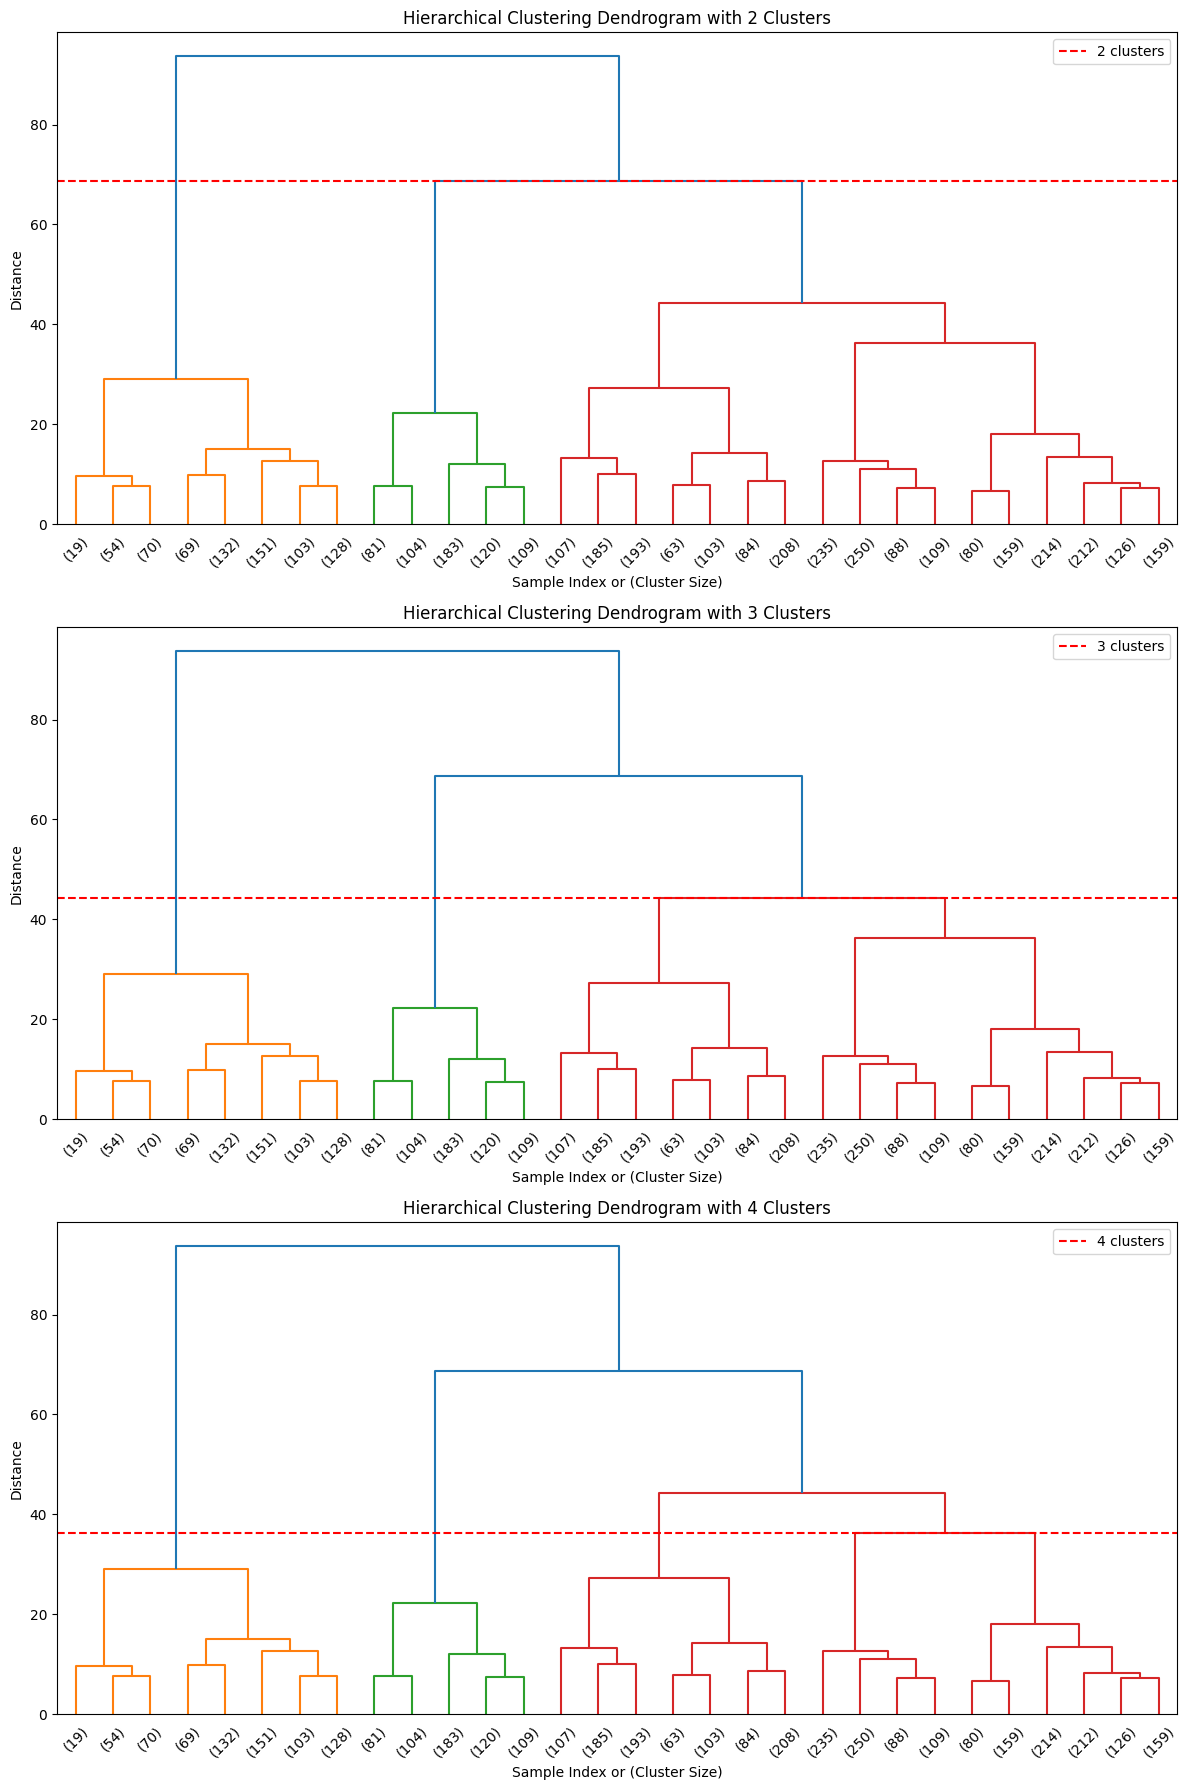

In [9]:
linked = linkage(scaled_data, method='ward') 
cut_heights = [linked[-2, 2], linked[-3, 2], linked[-4, 2]]

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

for ax, n_clusters, cut_height in zip(axes, [2, 3, 4], cut_heights):
    dendrogram(linked, truncate_mode='lastp', p=30, ax=ax, show_leaf_counts=True)
    ax.axhline(y=cut_height, color='red', linestyle='--', label=f'{n_clusters} clusters')
    ax.set_title(f'Hierarchical Clustering Dendrogram with {n_clusters} Clusters')
    ax.set_xlabel('Sample Index or (Cluster Size)')
    ax.set_ylabel('Distance')
    ax.legend()

plt.tight_layout()
plt.show()

Dendrograms show that:
- 3 clusters are too broad and oversimplify customer groups.
- 5 clusters offer a good balance with clear separation and practical segmentation.
- 6 clusters may lead to over-segmentation and reduced interpretability.

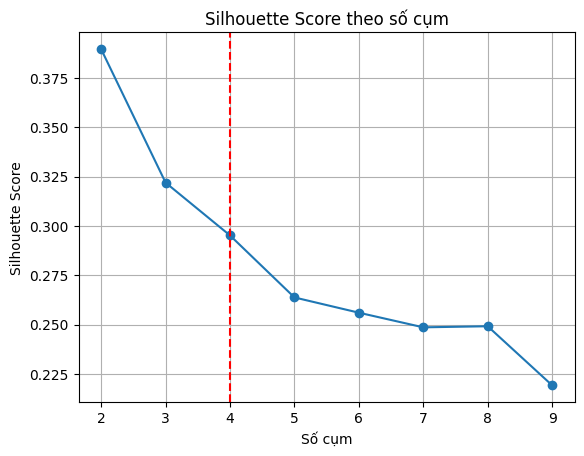

In [10]:
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    labels = fcluster(linked, k, criterion='maxclust')
    score = silhouette_score(scaled_data, labels)
    sil_scores.append(score)

# Vẽ biểu đồ
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score theo số cụm")
plt.xlabel("Số cụm")
plt.ylabel("Silhouette Score")
plt.axvline(x=4, color='r', linestyle='--', label=f'Optimal k = 4')
plt.grid(True)
plt.show()

Silhouette Score:
- Highest at k = 2, but too simple for real-world use.
- k = 4 has a slightly better score than k = 5, but the difference is minor.
- From k = 5 onward, the score decreases steadily.
- It provides clear, actionable clusters while maintaining acceptable clustering quality.

In [11]:
start_time = time.time()
linked = linkage(scaled_data, method='ward') 
end_time_1 = time.time()
labels = fcluster(linked, 5, criterion='maxclust')
end_time_2 = time.time()
print ("model training time:", round(end_time_1 - start_time,3),"sec")
print ("Prediction time:", round(end_time_2-end_time_1,3),"sec")

model training time: 0.372 sec
Prediction time: 0.011 sec


In [12]:
sil_score = silhouette_score(scaled_data, labels)
print("Silhouette Score:", round(sil_score, 2))
dbi_score = davies_bouldin_score(scaled_data, labels)
print("Davies-Bouldin Index:", round(dbi_score, 3))

Silhouette Score: 0.26
Davies-Bouldin Index: 1.063


In [13]:
df['Cluster'] = labels - 1
df

,Member_number,Recency,Frequency,Monetary,Cluster
0,2433,3,31,375.31,0
1,2193,91,27,361.45,0
2,1793,26,25,345.10,0
3,3289,4,29,334.15,0
4,2743,142,17,312.46,0
...,...,...,...,...,...
3893,4565,0,2,2.20,3
3894,3949,273,2,2.10,1
3895,1560,593,2,1.90,1
3896,1221,410,2,1.70,1


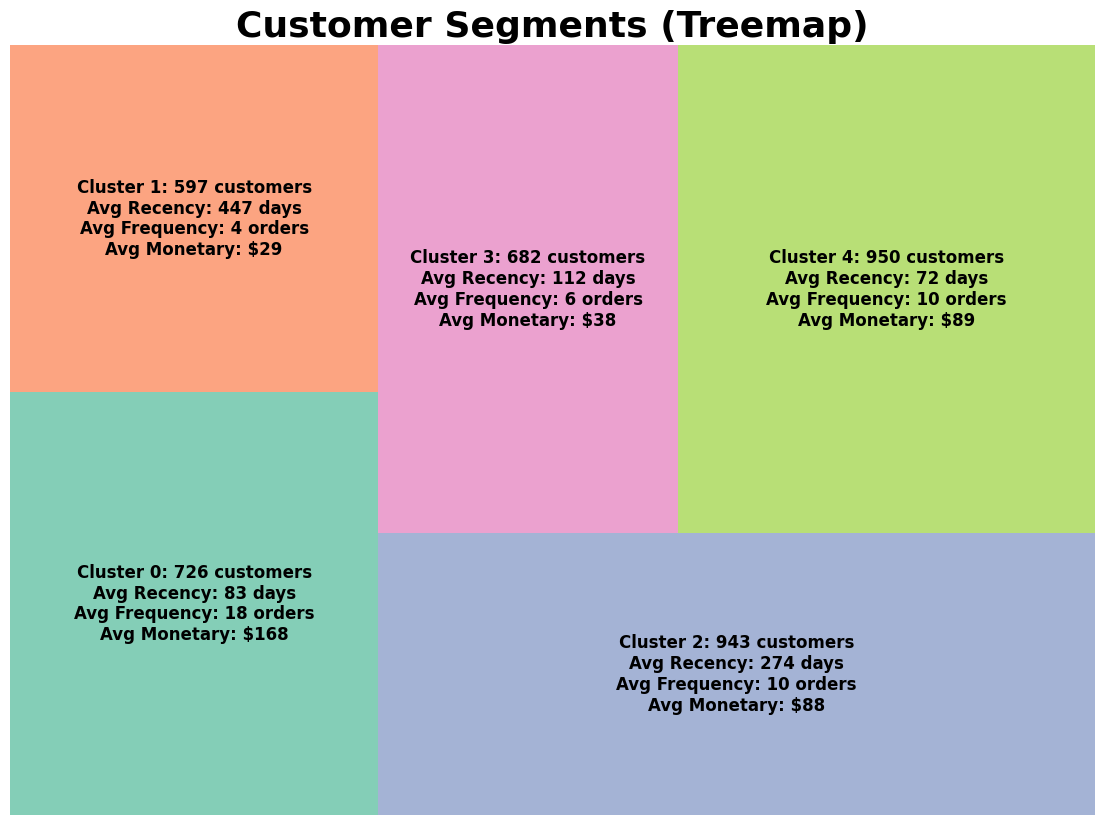

In [14]:
# Cluster summary
cluster_summary = df.groupby('Cluster').agg(
    Count=('Cluster', 'size'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).reset_index()


cluster_summary['label'] = cluster_summary.apply(
    lambda row: (
        f"Cluster {int(row['Cluster'])}: {int(row['Count'])} customers\n"
        f"Avg Recency: {row['Avg_Recency']:.0f} days\n"
        f"Avg Frequency: {row['Avg_Frequency']:.0f} orders\n"
        f"Avg Monetary: ${row['Avg_Monetary']:.0f}"
    ),
    axis=1
)


# Assign different colors using seaborn or matplotlib colormap
num_clusters = cluster_summary.shape[0]
colors = sns.color_palette("Set2", n_colors=num_clusters).as_hex()

# Plot treemap with colors
fig = plt.figure(figsize=(14, 10))
squarify.plot(
    sizes=cluster_summary['Count'],
    label=cluster_summary['label'],
    color=colors,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    alpha=0.8
)

plt.title("Customer Segments (Treemap)", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

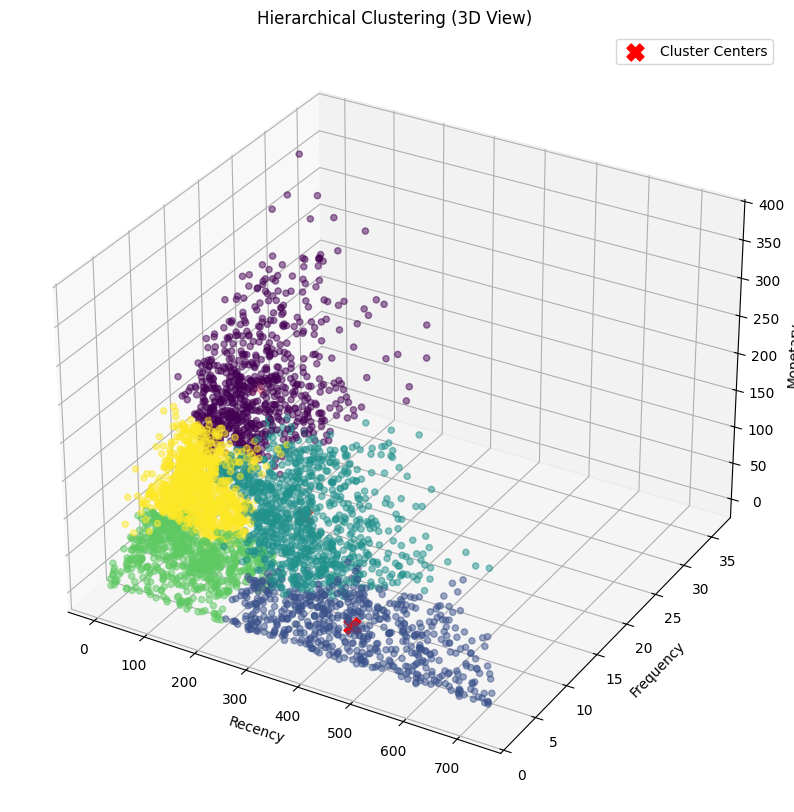

In [15]:
cluster_centers_scaled = np.array([scaled_data[labels == (i+1)].mean(axis=0) for i in range(3)
])

# Chuyển tâm cụm về không gian gốc
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)

# Bước 4: Vẽ biểu đồ 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Vẽ các điểm khách hàng
scatter = ax.scatter(
    df['Recency'], df['Frequency'], df['Monetary'],
    c=df['Cluster'], cmap='viridis', alpha=0.5
)

# Vẽ tâm cụm
ax.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
    c='red', s=150, marker='X', label='Cluster Centers'
)

# Nhãn trục
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Hierarchical Clustering (3D View)')
ax.legend()
plt.show()

**comment:**
- The plot shows well-separated clusters, each marked by different colors.
- Data points are clustered based on RFM behavior:  
    One cluster is clearly denser and has lower recency + higher frequency/monetary — likely loyal/high-value customers.  
    Another cluster with high recency + low frequency/monetary may represent lost or one-time buyers.

The separation is meaningful and reflects real behavioral differences, supporting the decision to use hierarchical clustering with the selected number of clusters